In [1]:
# def get_from_yd(link, file_name):
#   !wget https://getfile.dokpub.com/yandex/get/$link -O $file_name

In [16]:
# import numpy as np
# np.set_printoptions(precision=2)
# import json
# from tqdm import tqdm
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# import pandas as pd
# import importlib
# import matplotlib.pyplot as plt
# from navec import Navec
# navec = Navec.load(embedding_dir)
# import os
# import glob
# from importlib import reload

# import torch
# import models 
# from importlib import reload
# reload(models);
# import models
# from models import AverageMeter

# import collections
# %matplotlib inline
# import matplotlib.pyplot as plt
# from IPython import display
# from torch import nn
# from torch import optim
embedding_dir = 'temp_data/navec_hudlit_v1_12B_500K_300d_100q.tar'
EMB_DIM = 300
from navec import Navec

import load_data
import data_utils
import torch_utils 

import importlib
importlib.reload(load_data)
importlib.reload(data_utils)
importlib.reload(torch_utils)


import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import glob
import json
from tqdm import tqdm

import torch
from torch import optim

In [6]:
# load_data.read_from_disk_preprocess_save(read_dir='data/cases_small', save_dir='data/cases_small_preprocessed/',
#                                     lemmatize=False)

## Loading data

In [32]:
read_dir = 'data/cases_small_preprocessed/'
X, Y = load_data.read_preprocessed_from_disk_to_numeric_to_ram(read_dir, embedding_dir, EMB_DIM)

100%|█████████████████████████████████████████████████████████████████████████████████| 113/113 [13:41<00:00,  7.27s/it]


In [33]:
cases_info = pd.read_csv('data/cases_info.csv')

Mapping casenumbers to categories IDs.

In [34]:
cases_d = dict(zip(cases_info['Number'], cases_info['CategoryID']))

In [35]:
Y_id = np.array(list(map(lambda case: cases_d[case], Y)))

Removing not labeled examples and creating maping from category id to integer index of category 

In [37]:
indices = np.arange(len(X))
labeled_mask = (Y_id != -1)
X = X[labeled_mask]
Y = Y[labeled_mask]
Y_id = Y_id[labeled_mask]
indices = indices[labeled_mask]
id2i = dict(zip(set(Y_id), range(len(set(Y_id)))))
i2id = {v:k for k, v in id2i.items()}
Y_i = np.array(list(map(lambda _id: id2i[_id], Y_id)))

Train test split

In [41]:
(X_train, X_test,
Y_train_i, Y_test_i,
train_indices, test_indices
) = train_test_split(X, Y_i, indices, test_size=.2)

X_train_t = torch.Tensor(X_train)
X_test_t = torch.Tensor(X_test)

Y_train_it = torch.Tensor(Y_train_i).type(torch.long)
Y_test_it = torch.Tensor(Y_test_i).type(torch.long)

# X_train_t, X_test_t, Y_train_it, Y_test_it = torch_utils.custom_train_test_split(X, Y_i)

Network Configurations

In [42]:
# INPUT_DIM = X_train_t.shape[-1]
# print(f'INPUT_DIM : {INPUT_DIM}')
# OUTPUT_DIM = len(np.unique(Y_i))  # _classes
# print(f'OUTPUT_DIM : {OUTPUT_DIM}')
    
# BATCH_SIZE = 2**12
# print(f'BATCH_SIZE : {BATCH_SIZE}')

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# print(DEVICE)

# # linear_model = models.LinearModelCustom2(INPUT_DIM, OUTPUT_DIM)
# # linear_model = models.LinearModel(INPUT_DIM, OUTPUT_DIM)
# model = models.MLP2(INPUT_DIM, OUTPUT_DIM)
# model.to(DEVICE)

# HISTORY = collections.defaultdict(list)

INPUT_DIM, OUTPUT_DIM, BATCH_SIZE, DEVICE, model, HISTORY = torch_utils.network_configs(X_train_t, Y_i, True)

INPUT_DIM : 300
OUTPUT_DIM : 36
BATCH_SIZE : 4096
cpu


#### TRAINING

In [43]:
# optimizer = optim.SGD(linear_model.parameters(), lr=1e-2, momentum=0.1, nesterov=True, weight_decay=1e-1)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

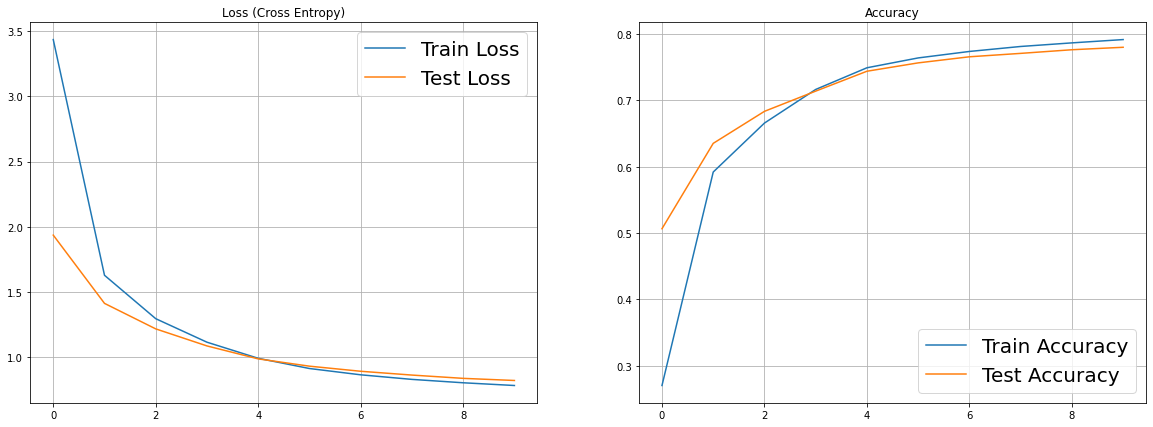

In [44]:
model, HISTORY, test_accuracy_meter= (
    torch_utils.train(
        NUM_EPOCH = 10,
        BATCH_SIZE = BATCH_SIZE,
        DEVICE = DEVICE,
        optimizer = optimizer,
        HISTORY = HISTORY,
        X_train=X_train_t, Y_train=Y_train_it,
        X_test=X_test_t, Y_test=Y_test_it,
        model = model,
        verbose=True)
)

## Analyzing mistakes 

In [46]:
read_dir = 'data/cases_small_preprocessedLEMM/'
Z_len_m = []
Z_len = []
navec = Navec.load(embedding_dir)

for i, (x_str, y) in enumerate(load_data.yield_preprocessed_json_from_disk(read_dir)):
    if i in test_indices:
#         doc_counts = data_utils.build_count_dict(x_str.split(' '))
#         doc_vec = doc_to_vector(doc_counts, f_to_idx, idf_measures, use_idf=True)

        doc_vec = np.zeros(EMB_DIM)
        counts = 0
        for token in x_str.split(' '):
            if token in navec:
                doc_vec += navec[token]
                counts += 1

        if counts:
            doc_vec = doc_vec / counts
        
        y_id = cases_d[y]
        y_idx = id2i[y_id]  
        
        with torch.no_grad():
            logits = model.forward(torch.Tensor(doc_vec[None]))
            prediction = torch.argmax(logits, 1).item()
        
        n_tokens = len(x_str.split())
        
        if prediction != y_idx:
            
            Z_len_m.append(n_tokens)
        else:
            Z_len.append(n_tokens)
#             print(f'n_tokens :: {n_tokens}')
#             print('==========================')
#             print(x_str)
#             print('==========================')
#             break

Z_len = np.sort(Z_len)
Z_len_m = np.sort(Z_len_m)


100%|█████████████████████████████████████████████████████████████████████████████████| 113/113 [02:37<00:00,  1.40s/it]


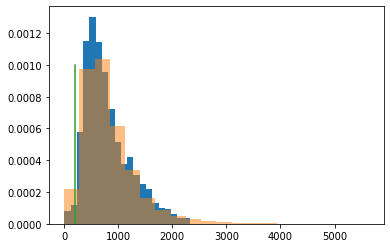

In [47]:
# Z_len = np.array(Z_len)

plt.hist(Z_len[:-100], density=True, bins=20);
plt.hist(Z_len_m[:-20], density=True, bins=20, alpha=.5)
plt.plot(np.linspace(0, 0.001)*0 + 200, np.linspace(0, 0.001))

## Several runs metrics

In [50]:
N_trials = 10
accuracy_list = []
for _ in tqdm(range(N_trials)):
    X_train_t, X_test_t, Y_train_it, Y_test_it = torch_utils.custom_train_test_split(X, Y_i)
    INPUT_DIM, OUTPUT_DIM, BATCH_SIZE, DEVICE, model, HISTORY = torch_utils.network_configs(X_train_t, Y_i, False)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    model, HISTORY, test_accuracy_meter= (
    torch_utils.train(
        NUM_EPOCH = 5,
        BATCH_SIZE = BATCH_SIZE,
        DEVICE = DEVICE,
        optimizer = optimizer,
        HISTORY = HISTORY,
        X_train=X_train_t, Y_train=Y_train_it,
        X_test=X_test_t, Y_test=Y_test_it,
        model = model,
        verbose=False)
    )
    
    accuracy_list.append(test_accuracy_meter.avg)
accuracy_array = np.array(accuracy_list)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.06it/s]


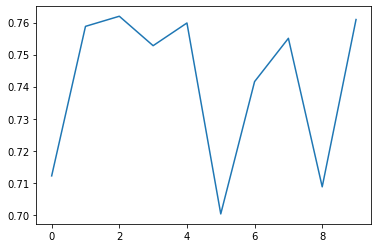

In [51]:
plt.plot(accuracy_array)